In [1]:
# Install the necessary packages
%pip install gymnasium pyvirtualdisplay
%pip install pygame


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\ethan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\ethan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
## Import modules

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import random
import itertools

In [2]:
## Define helper functions

def color(val, max):
    if val > 0:
      return (int(255*(1-val/max)),255,int(255*(1-val/max)))
    elif val == 0:
      return (255,255,255)
    else:
      return (255,int(255*(1+val/max)),int(255*(1+val/max)))

In [3]:
## Define environment class

class ParkingLot(gym.Env):

  def __init__(self, num_lanes, spots_per_lane, amt_full = 0.5):

    self.width = num_lanes * 3 + 1
    self.height = spots_per_lane + 2

    self.observation_space = spaces.Box(low=np.array([0, 0, 0]), high=np.array([self.height-1, self.width-1, 3]), shape=(3,), dtype=np.int32) # {y, x, direction (R,D,L,U)}
    self.action_space = spaces.Discrete(3) # {Go forward, turn right, turn left}

    self.agent_state = np.array([0,0,0])
    self.grid = np.zeros((self.height, self.width))

    for l in range(1, num_lanes+1):
      self.grid[1:spots_per_lane+1, l*3-2] = 2*l-1
      self.grid[1:spots_per_lane+1, l*3-1] = 2*l

    self.lane_idx = np.array([l*3+1 for l in range(num_lanes)] + [l*3+2 for l in range(num_lanes)])
    for s in range(spots_per_lane):
      self.grid[s+1, self.lane_idx] += s

    # Add cars
    r_max = np.max(self.grid)
    p = (0.5+amt_full) * self.grid / r_max

    for l in range(1, num_lanes+1):
      for s in range(spots_per_lane):
        if random.random() < p[s+1, l*3-2]:
          self.grid[s+1, l*3-2] = -r_max
        if random.random() < p[s+1, l*3-1]:
          self.grid[s+1, l*3-1] = -r_max

  def __get_obs(self):
    return self.agent_state

  def reset(self, seed=None, options=None):
    super().reset(seed=seed)
    self.agent_state = np.array([0,0,0])
    observation = self.__get_obs()
    info = None
    return observation, info

  def compute_reward(self, observation):
    if observation[0] in np.arange(self.height) and observation[1] in np.arange(self.width):
      return self.grid[observation[0], observation[1]]
    else:
      return -10

  def step(self, action):

      dir = self.agent_state[2]
      if action == 0:
        self.agent_state[0 if dir%2==1 else 1] += -1 if dir//2==1 else 1
      elif action == 1:
        self.agent_state[2] = (dir + 1) % 4
      elif action == 2:
        self.agent_state[2] = (dir - 1) % 4

      observation = self.__get_obs()
      reward = self.compute_reward(observation)
      terminated = reward != 0

      return observation, reward, terminated, False, None

  def _render_frame(self, screen, window_width, window_height):
    w = window_width/self.width
    h = window_height/self.height
    for r in range(self.height):
      for c in range(self.width):
        pygame.draw.rect(screen, color(self.grid[r, c], np.max(np.abs(self.grid))), pygame.Rect(c*w, r*h, w, h))
    pygame.draw.polygon(screen, 'blue', self.coordinates(w, h))

  def render(self, screen, window_width, window_height):
    return self._render_frame(screen, window_width, window_height)

  def coordinates(self, w, h):
    if self.agent_state[2] == 0:
      return [
        (self.agent_state[1]*w+w//4, self.agent_state[0]*h+h//4),
        (self.agent_state[1]*w+3*w//4, self.agent_state[0]*h+h//2),
        (self.agent_state[1]*w+w//4, self.agent_state[0]*h+3*h//4)]
    elif self.agent_state[2] == 1:
      return [
        (self.agent_state[1]*w+w//4, self.agent_state[0]*h+h//4),
        (self.agent_state[1]*w+w//2, self.agent_state[0]*h+3*h//4),
        (self.agent_state[1]*w+3*w//4, self.agent_state[0]*h+h//4)]
    elif self.agent_state[2] == 2:
      return [
        (self.agent_state[1]*w+w//4, self.agent_state[0]*h+h//2),
        (self.agent_state[1]*w+3*w//4, self.agent_state[0]*h+h//4),
        (self.agent_state[1]*w+3*w//4, self.agent_state[0]*h+3*h//4)]
    elif self.agent_state[2] == 3:
      return [
        (self.agent_state[1]*w+w//2, self.agent_state[0]*h+h//4),
        (self.agent_state[1]*w+w//4, self.agent_state[0]*h+3*h//4),
        (self.agent_state[1]*w+3*w//4, self.agent_state[0]*h+3*h//4)]

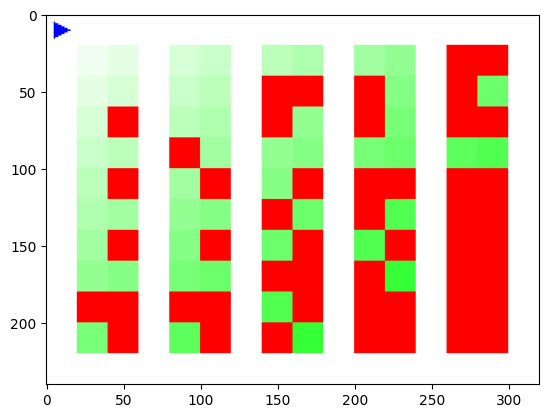

In [19]:
## Generate example environment

import cv2
from IPython.display import clear_output
# from google.colab.patches import cv2_imshow
import time
import matplotlib.pyplot as plt

lot = ParkingLot(5, 10, 0.5)
grid_L = 20
window_width = lot.width * grid_L
window_height = lot.height * grid_L
pygame.init()
screen = pygame.display.set_mode((window_width, window_height))
lot.render(screen, window_width, window_height)
view = pygame.surfarray.array3d(screen)
view = view.transpose([1, 0, 2])
img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
plt.imshow(view)
plt.show()
# cv2.imshow("Parking Lot Simulator", img_bgr)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [6]:
## Implement Q-learning

class QLearning():
  def __init__(self, env, exploration, gamma, alpha, obs_space_n, action_space_n):
    self.env = env
    self.exploration = exploration
    self.gamma = gamma
    self.alpha = alpha
    self.q_table = np.zeros((obs_space_n, action_space_n))

  def sample_action(self, observation):
    r = random.random()
    if r < self.exploration:
      action = self.env.action_space.sample()
    else:
      action = np.argmax(self.q_table[observation])
    return action

  def update_table(self, observation, action, reward, new_observation, terminated):
    old_q = self.q_table[observation, action]
    if new_observation >= 0 and new_observation < self.q_table.shape[0]:
      sample = reward + self.gamma * np.max(np.delete(self.q_table[new_observation], action))
    else:
      sample = reward + self.gamma * -1
    new_q = (1 - self.alpha) * old_q + self.alpha * sample
    self.q_table[observation, action] = new_q

In [20]:
## Train agent

lot = ParkingLot(5, 10, 0.5)
q_learning = QLearning(lot, .3, .99, .9, np.product(lot.observation_space.high+1), lot.action_space.n)
n = 10000

for i in range(n):
  terminated = False
  lot.reset()
  while not terminated:
    s = lot.agent_state.copy()
    s_ind = (s[0] * lot.width + s[1]) * 4 + s[2]
    a = q_learning.sample_action(s_ind)
    s1, R, terminated, truncated, info = lot.step(a)
    s1_ind = (s1[0] * lot.width + s1[1]) * 4 + s1[2]
    q_learning.update_table(s_ind, a, R, s1_ind, terminated)

In [21]:
## Test agent

grid_L = 20
window_width = lot.width * grid_L
window_height = lot.height * grid_L
pygame.init()
screen = pygame.display.set_mode((window_width, window_height))


q_learning.exploration = 0.0
for i in range(0, 1):
  observation, info = lot.reset()
  terminated = False
  lot.render(screen, window_width, window_height)
  img_bgr = cv2.cvtColor(pygame.surfarray.array3d(screen).transpose([1, 0, 2]), cv2.COLOR_RGB2BGR)
  cv2.imshow("Parking Lot Simulator", img_bgr)
  cv2.waitKey(0)
  clear_output()
  while not terminated:
    action = q_learning.sample_action((observation[0] * lot.width + observation[1]) * 4 + observation[2])
    observation, reward, terminated, truncated, info = lot.step(action)
    lot.render(screen, window_width, window_height)
    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2.imshow("Parking Lot Simulator", img_bgr)
    cv2.waitKey(0)
cv2.destroyAllWindows()